In [1]:
import collections 
from openpyxl.workbook import workbook
import pandas as pd
import numpy as np
import shutil
import math
import sys
import time
from openpyxl import load_workbook
#import xlwings as xw
import os
import requests #import library
import json
import re
import tempfile
import shutil
import heapq

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import mplcursors

In [2]:
def mapLines(data, crs):
    geometry = [LineString(xy) for xy in zip(zip(data['lon1'], data['lat1']), zip(data['lon2'], data['lat2']))]
    geo_df = gpd.GeoDataFrame(data, crs = crs, geometry = geometry)
    return geo_df

def mapPoints(data, crs):
    geometry = [Point(xy) for xy in zip(data['lon1'], data['lat1'])]
    geo_df = gpd.GeoDataFrame(data, crs = crs, geometry = geometry)
    return geo_df

def nodeLatLon(df, nodes):
    i = 1
    for bus in nodes:
        df = pd.merge(df, node_lookup, how = 'left', left_on = bus, right_on  = 'node')
        df = df.rename(columns = {'lat':'lat'+ str(i), 'lon':'lon'+ str(i)})
        i = i + 1
    return df

def findPath(node, start, pathDict):
    parent = parentdf.loc[node][start]
    
    if parent == -1:
        return
    
    findPath(parent, start, pathDict)
    
    pathDict[node] = parent
    
    return pathDict;

def algoCheck(node, old, crs, ax):
    new = final2.at[node, 'new_bus']
    pathDict1 = collections.defaultdict(dict) #dictionary of edges and vertices (graph)
    path1 = findPath(node, new, pathDict1)
    newPath = pd.DataFrame.from_dict(path1, orient='index')
    newPath.reset_index(inplace=True)
    newPath = newPath.rename(columns = {'index':'start_node', 0:'end_node'})
    newerPath = nodeLatLon(newPath, ['start_node', 'end_node'])
    mapNewPath = mapLines(newerPath, crs)
    mapNewPath.plot(ax=ax, color = 'orange')
    
    pathDict2 = collections.defaultdict(dict) #dictionary of edges and vertices (graph)
    path2 = findPath(node, old, pathDict2)
    oldPath = pd.DataFrame.from_dict(path2, orient='index')
    oldPath.reset_index(inplace=True)
    oldPath = oldPath.rename(columns = {'index':'start_node', 0:'end_node'})
    olderPath = nodeLatLon(oldPath, ['start_node', 'end_node'])
    mapOldPath = mapLines(olderPath, crs)
    mapOldPath.plot(ax=ax, color = 'purple')
    return

In [3]:
#Imports data from API and formats to excel

x = requests.get('http://206.12.95.90/transmission_lines?province=ON')
node_voltage = {500}

path = "/home/nathan/Desktop/Maps"

suffix = ".json"
path1 =f"{path[0].upper()}{path[1:]}{suffix}"
suffix = "formatted.json"
path2 = f"{path[0].upper()}{path[1:]}{suffix}"
suffix = ".xlsx"
path3 = f"{path[0].upper()}{path[1:]}{suffix}"
with open(path1, "w") as output:
    for variable in x.json():
        json.dump(variable,output)

#the json.dump outputs the data into a json file with no commas "}{" the few lines
#code below change it to "},{" which makes it readable by panada
with open(path1, 'r') as input, open(path2, 'w') as output:
    for line in input:
        line = re.sub('}{', '},{', line)
        output.write('    '+line)
os.remove(path1)

df_json = pd.read_json(path2, lines=True)
df_json.to_excel(path3)

os.remove(path2)

In [5]:
#Creates dataframes

raw_data = pd.read_excel(path3)
raw_node_data = pd.read_csv("ON-Nodes.csv")

columns = ["from_bus", "to_bus", "distance", 'voltage']
transmission_data = pd.DataFrame([], columns=columns)
transmission_data['from_bus'] = raw_data['starting_node_code']
transmission_data['to_bus'] = raw_data['ending_node_code']
transmission_data['distance'] = raw_data['line_segment_length_km']
transmission_data['voltage'] = raw_data['voltage_in_kv']

columns = ['node', 'lat', 'lon']
node_lookup = pd.DataFrame([], columns = columns)
node_lookup['node'] = raw_node_data['node_code']
node_lookup['lat'] = raw_node_data['latitude']
node_lookup['lon'] = raw_node_data['longitude']


main_nodes = transmission_data[transmission_data['voltage'].isin(node_voltage)] #storing set of 'main nodes' to use as starting nodes
to_nodes = set(main_nodes['to_bus'])
from_nodes = set(main_nodes['from_bus'])
main_nodes = to_nodes.union(from_nodes)
main = pd.DataFrame(main_nodes, columns = ['node'])

lines = pd.DataFrame([], columns = ['start_node', 'end_node'])
lines['start_node'] = raw_data['starting_node_code']
lines['end_node'] = raw_data['ending_node_code']

main = nodeLatLon(main, ['node'])
lines = nodeLatLon(lines, ['start_node', 'end_node'])

In [6]:
#Running Dijkstra

graph = collections.defaultdict(dict) #dictionary of edges and vertices (graph)

for index,row in transmission_data.iterrows(): #iterate through rows of dataframe
    graph[row['from_bus']][row['to_bus']] = row['distance'] #set edge with to node, from node and distance
    graph[row['to_bus']][row['from_bus']] = row['distance'] #set same edge in opposite direction (bidirectional)

distances = {i:{ j: float("inf") for j in graph} for i in main_nodes} #dictionary of shortest distances from each main_node {main_node: {every_node:every_distance}}
parents = {i:{ j: 0 for j in node_lookup['node']} for i in main_nodes} #dictionary of parent nodes

for start_node in main_nodes:
    distances[start_node][start_node] = 0 #setting first node distance as 0
    parents[start_node][start_node] = -1
    min_dist = [(0,start_node)] #heap of shortest distances (distance, node)
    visited = set() #set of all visited nodes
    
    while min_dist: #while heap is not empty
            
        cur_dist, cur = heapq.heappop(min_dist) #pop smallest value from heap, store it's distance and node
       
        if cur in visited: continue #skip this loop if current node has been visited
        
        visited.add(cur) #add current node to set of visited nodes
            
        for neighbor in graph[cur]: #iterate through neighbors of current node
        
            if neighbor in visited: continue #skip if in set of visited nodes
            
            this_dist = cur_dist + graph[cur][neighbor] #calculate new distance = distance to neighbor + distance to current node
        
            if this_dist  < distances[start_node][neighbor]: #check which is smaller
                distances[start_node][neighbor] = this_dist #store if new distance is smaller
                parents[start_node][neighbor] = cur
                heapq.heappush(min_dist, (this_dist, neighbor)) #push neighbor to heap

   

In [7]:
#Formatting output and saving to excel
result = pd.DataFrame.from_dict(distances)
parentdf = pd.DataFrame.from_dict(parents)
new = {'new_bus' : result.idxmin(axis=1)}

final = pd.DataFrame(new)
final2 = pd.DataFrame(new)

final.reset_index(inplace=True)
final = final.rename(columns = {'index':'old_bus'})

node = nodeLatLon(final, ['old_bus', 'new_bus'])       
final = nodeLatLon(final, ['old_bus', 'new_bus'])

In [11]:
province_map = gpd.read_file('lpr_000b16a_e.shp')

crs = {'init':'EPSG:4326'}

mapNodes = mapPoints(node, crs)
mapMainNodes = mapPoints(main, crs)
mainLines = mapLines(final, crs)
allLines = mapLines(lines, crs)

/home/nathan/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/nathan/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/nathan/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When 

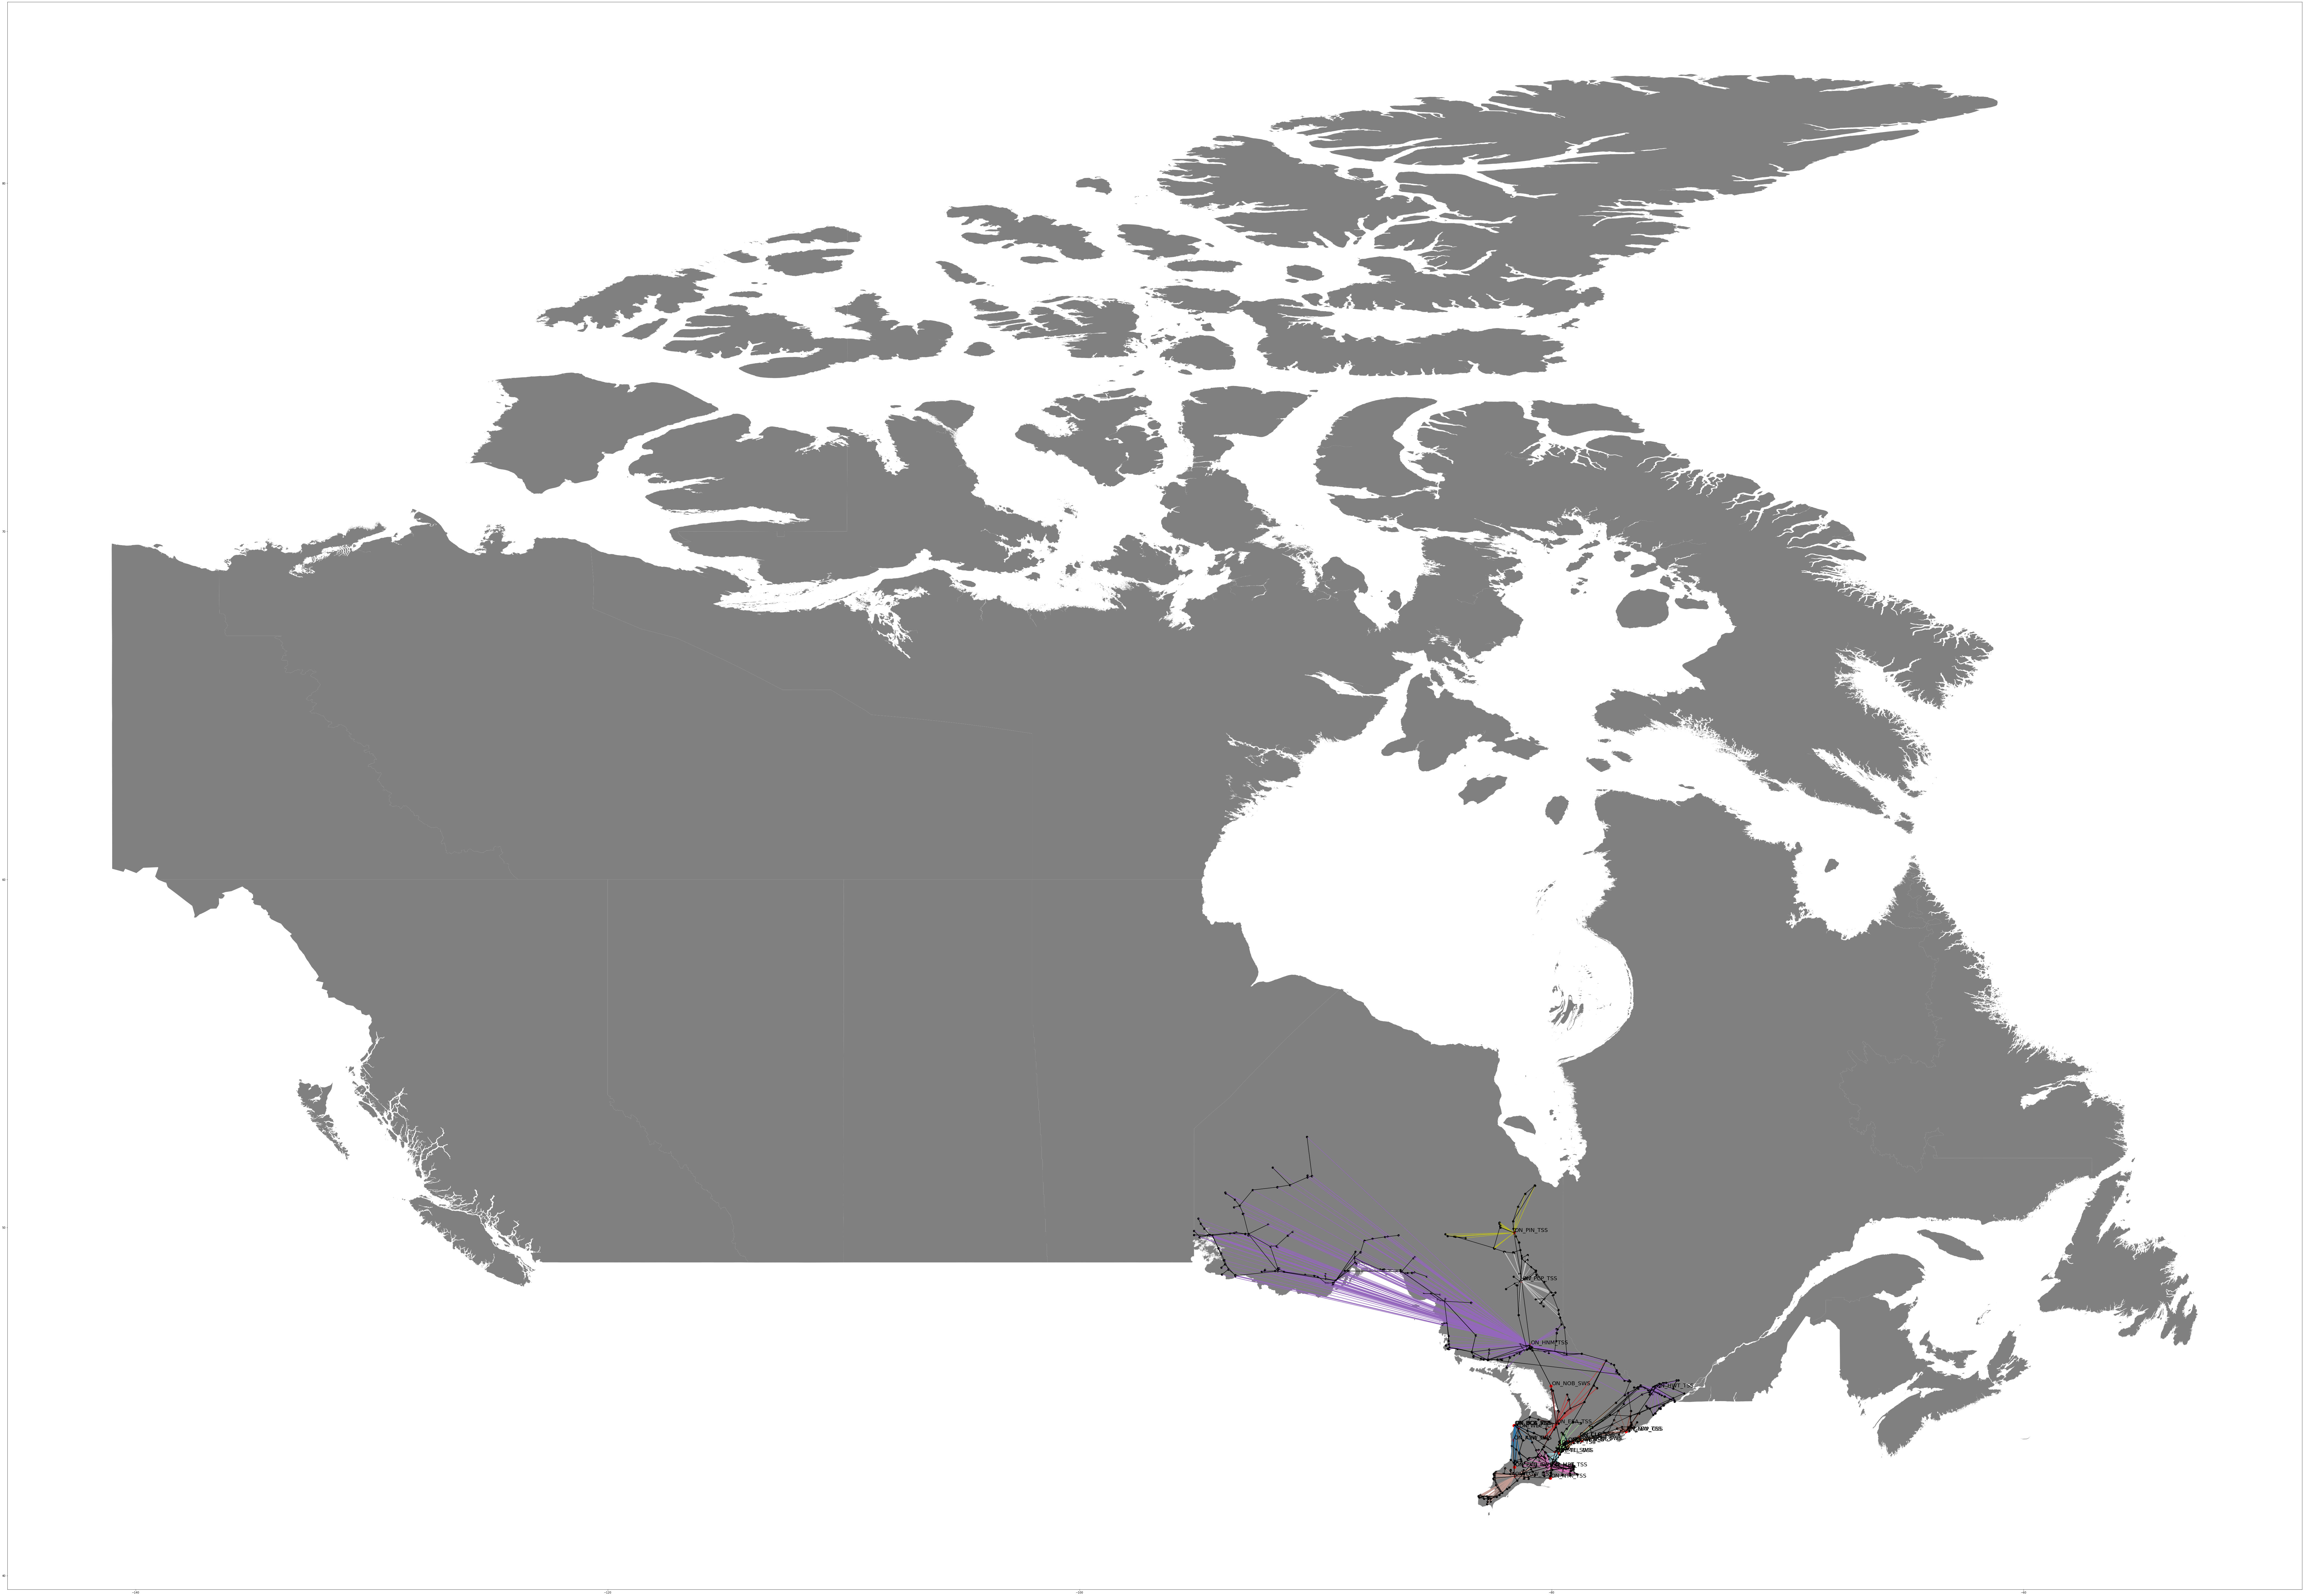

In [12]:
fig, ax = plt.subplots(figsize = (150,150))
province_map.to_crs(epsg = 4326).plot(ax=ax, color = 'gray')
mapNodes.plot(ax=ax, color = 'black', markersize = 50) #Nodes
mapMainNodes.plot(ax=ax, color = 'red', markersize = 100) #Main Nodes
mainLines.plot(ax=ax, column = 'new_bus', cmap = 'tab20') #Lines from nodes to main nodes
allLines.plot(ax=ax, color = 'black') #All lines


for x, y, label in zip(main['lon1'], main['lat1'], main['node']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize = 20)

plt.savefig("ONMAP")

In [ ]:
ax.clear()